In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, IsolationForest
from catboost import CatBoostRegressor
import xgboost as xgb

from read_data import (
    load_lab_data, load_field_data,
    add_bl_stat_masks
)

from utils import  get_model, get_importance

def plot_regression_results(
    y_true, y_pred,
    x_axis=None,
    title="Regression",
    xlabel="Истинное значение",
    ylabel="Предсказание",
    line45=True
):
    plt.figure(figsize=(6, 5))
    if x_axis is not None:
        plt.scatter(x_axis, y_true, s=6, alpha=0.4, label="Истинные")
        plt.scatter(x_axis, y_pred, s=6, alpha=0.4, label="Модель")
    else:
        plt.scatter(y_true, y_pred, s=8, alpha=0.5)
    if line45:
        mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        plt.plot([mn, mx], [mn, mx], 'k--', lw=1, label="Идеал")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def train_for_gas(
    gas_name,
    df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    sens_model_name='catboost',
    cross_gases=None,
    cross_gases_in_bl=False,
    draw=True,
    use_grads=False
):
    signal_col = f"{gas_name}op1"
    temp_col = f"{gas_name}t"
    hum_col = "MH"
    bl_col = f"{signal_col}_bl" if bl_method == 'rolling' else f"{signal_col}_bl_auto"
    stat_col = f"{signal_col}_stat" if stat_method == 'rolling' else f"{signal_col}_stat_auto"
    bl_mask = df[bl_col].fillna(False)
    stat_mask = df[stat_col].fillna(False)

    if cross_gases is None:
        cross_gases = []
    cross_feats = [f'{g}op1' for g in cross_gases if f'{g}op1' in df.columns]
    grad_feats = [f'{temp_col}_grad', 'MH_grad', f'{signal_col}_grad']
    base_feats = [temp_col, hum_col]
    features_bl = base_feats + (cross_feats if cross_gases_in_bl else []) + (grad_feats if use_grads else [])
    features_stat = base_feats + cross_feats + (grad_feats if use_grads else []) + [gas_name]

    bl_df = df.loc[bl_mask].dropna(subset=[signal_col] + features_bl)
    stat_df = df.loc[stat_mask].dropna(subset=[signal_col] + features_stat)
    if len(bl_df) < 10 or len(stat_df) < 10:
        return {'gas': gas_name, 'error': 'Недостаточно данных для обучения'}

    X_bl = bl_df[features_bl].values
    y_bl = bl_df[signal_col].values
    X_stat = stat_df[features_stat].values
    y_signal = stat_df[signal_col].values
    X_target = stat_df[[gas_name]].values

    bl_model = get_model(bl_model_name)
    bl_model.fit(X_bl, y_bl)
    y_bl_pred = bl_model.predict(X_bl)

    bl_pred_for_sens = bl_model.predict(X_stat[:, :len(features_bl)])
    delta_signal = y_signal - bl_pred_for_sens
    sens_model = get_model(sens_model_name)
    sens_model.fit(X_target, delta_signal)
    sens_pred = sens_model.predict(X_target)

    signal_rec = bl_pred_for_sens + sens_pred
    r2_sens = r2_score(y_signal, signal_rec)
    mse_sens = mse(y_signal, signal_rec)
    rmse_sens = np.sqrt(mse(y_signal, signal_rec))
    nrmse_sens = rmse_sens / np.std(y_signal) if np.std(y_signal) > 0 else np.nan

    r2_bl = r2_score(y_bl, y_bl_pred)
    mse_bl = mse(y_bl, y_bl_pred)
    rmse_bl = np.sqrt(mse(y_bl, y_bl_pred))
    nrmse_bl = rmse_bl / np.std(y_bl) if np.std(y_bl) > 0 else np.nan


    feat_imp_bl = get_importance(bl_model, features_bl)
    feat_imp_sens = get_importance(sens_model, [gas_name])

    if draw:
        plot_regression_results(
            y_true=y_bl,
            y_pred=y_bl_pred,
            title=f"{gas_name} — BL model:\nR2 = {r2_bl:.3f} | MSE = {mse_bl:.3f}",
            xlabel="op1_bl (истинный)",
            ylabel="op1_bl (предсказанный)"
        )
        plot_regression_results(
            y_true=y_signal,
            y_pred=signal_rec,
            x_axis=X_target.squeeze() if X_target.shape[1] == 1 else None,
            title=f"{gas_name} — Sens full:\nR2 = {r2_sens:.3f} | MSE = {mse_sens:.3f}",
            xlabel=f'{gas_name} (мкг/м³)',
            ylabel=f'Сигнал, восстановленный',
            line45=False
        )

    return {
        'gas': gas_name,
        'n_bl': len(bl_df),
        'n_stat': len(stat_df),
        'R2_bl': r2_bl,
        'nrmse_bl': nrmse_bl,
        'R2_sens': r2_sens,
        'nrmse_sens': nrmse_sens,
        'model_bl': bl_model,
        'model_sens': sens_model,
        'feat_imp_bl': feat_imp_bl,
        'feat_imp_sens': feat_imp_sens
    }

def train_for_gas_conc(
    gas_name,
    df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    conc_model_name='catboost',
    cross_gases=None,
    cross_gases_in_bl=False,
    draw=True,
    use_grads=False
):
    signal_col = f"{gas_name}op1"
    temp_col = f"{gas_name}t"
    hum_col = "MH"
    bl_col = f"{signal_col}_bl" if bl_method == 'rolling' else f"{signal_col}_bl_auto"
    stat_col = f"{signal_col}_stat" if stat_method == 'rolling' else f"{signal_col}_stat_auto"
    bl_mask = df[bl_col].fillna(False)
    stat_mask = df[stat_col].fillna(False)

    if cross_gases is None:
        cross_gases = []
    cross_feats = [f'{g}op1' for g in cross_gases if f'{g}op1' in df.columns]
    grad_feats = [f'{temp_col}_grad', 'MH_grad', f'{signal_col}_grad']
    base_feats_bl = [temp_col, hum_col]
    features_bl = base_feats_bl + (cross_feats if cross_gases_in_bl else []) + (grad_feats if use_grads else [])

    base_feats_conc = [signal_col, temp_col, hum_col]
    features_conc = base_feats_conc + cross_feats + (grad_feats if use_grads else [])

    bl_df = df.loc[bl_mask].dropna(subset=[signal_col] + features_bl)
    stat_df = df.loc[stat_mask].dropna(subset=features_conc + [gas_name])
    if len(bl_df) < 10 or len(stat_df) < 10:
        return {'gas': gas_name, 'error': 'Недостаточно данных для обучения'}

    X_bl = bl_df[features_bl].values
    y_bl = bl_df[signal_col].values

    X_conc = stat_df[features_conc].values
    y_conc = stat_df[gas_name].values

    bl_model = get_model(bl_model_name)
    bl_model.fit(X_bl, y_bl)
    y_bl_pred = bl_model.predict(X_bl)

    conc_model = get_model(conc_model_name)
    conc_model.fit(X_conc, y_conc)
    y_conc_pred = conc_model.predict(X_conc)

    r2_bl = r2_score(y_bl, y_bl_pred)
    mse_bl = mse(y_bl, y_bl_pred)    
    rmse_bl = np.sqrt(mse(y_bl, y_bl_pred))
    nrmse_bl = rmse_bl / np.std(y_bl) if np.std(y_bl) > 0 else np.nan

    r2_conc = r2_score(y_conc, y_conc_pred)
    mse_conc = mse(y_conc, y_conc_pred)
    rmse_conc = np.sqrt(mse(y_conc, y_conc_pred))
    nrmse_conc = rmse_conc / np.std(y_conc) if np.std(y_conc) > 0 else np.nan

    feat_imp_bl = get_importance(bl_model, features_bl)
    feat_imp_conc = get_importance(conc_model, features_conc)

    if draw:
        plot_regression_results(
            y_true=y_bl,
            y_pred=y_bl_pred,
            title=f"{gas_name} — BL model:\nR2 = {r2_bl:.3f} | MSE = {mse_bl:.3f}",
            xlabel="op1_bl (истинный)",
            ylabel="op1_bl (предсказанный)"
        )
        plot_regression_results(
            y_true=y_conc,
            y_pred=y_conc_pred,
            title=f"{gas_name} — Regression model:\nR2 = {r2_conc:.3f} | MSE = {mse_conc:.3f}",
            xlabel=f'{gas_name} (истинная)',
            ylabel=f'{gas_name} (предсказанная)'
        )

    return {
        'gas': gas_name,
        'n_bl': len(bl_df),
        'n_stat': len(stat_df),
        'R2_bl': r2_bl,
        'nrmse_bl': nrmse_bl,
        'R2_conc': r2_conc,
        'nrmse_conc': nrmse_conc,
        'model_bl': bl_model,
        'model_conc': conc_model,
        'feat_imp_bl': feat_imp_bl,
        'feat_imp_conc': feat_imp_conc
    }

def print_result(result, mode="Sens"):
    if 'error' in result:
        print(f"[{result['gas']}] Обучение не выполнено: {result['error']}")
        return
    print(f"\n====== Итоги обучения для газа: {result['gas']} ({mode}) ======")
    print(f"Количество baseline (bl):   {result['n_bl']}")
    print(f"Количество рабочих (stat):  {result['n_stat']}")
    print(f"Качество baseline (BL):     R2 = {result['R2_bl']:.3f} | nrMSE = {result['nrmse_bl']:.3f}")
    if mode == "Sens":
        print(f"Качество sens-модели (signal): R2 = {result['R2_sens']:.3f} | nrMSE = {result['nrmse_sens']:.3f}")
    else:
        print(f"Качество regression-модели (conc): R2 = {result['R2_conc']:.3f} | nrMSE = {result['nrmse_conc']:.3f}")
    if result['n_stat'] == 0:
        print(f"Нет ни одной рабочей точки stat!")
    print("========================================\n")



NO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


NO2: 379983 baseline (после фильтрации)
NO2: baseline = 379983, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


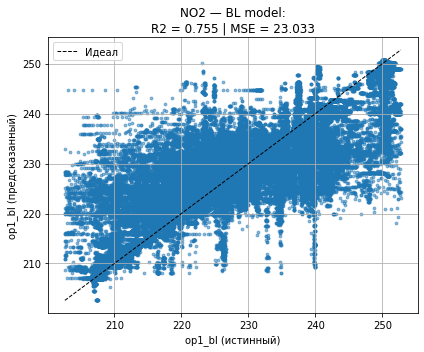

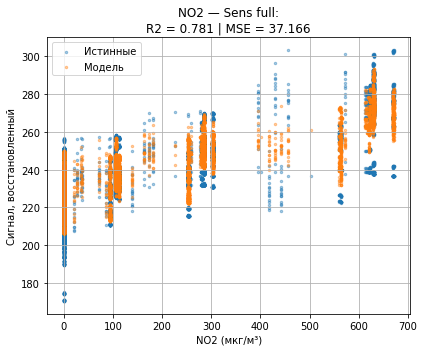


====== Итоги обучения для газа: NO2 (Sens) ======
Количество baseline (bl):   377241
Количество рабочих (stat):  77644
Качество baseline (BL):     R2 = 0.755 | nrMSE = 0.495
Качество sens-модели (signal): R2 = 0.781 | nrMSE = 0.468

CO: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CO: 389660 baseline (после фильтрации)
CO: baseline = 389660, stat = 30, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


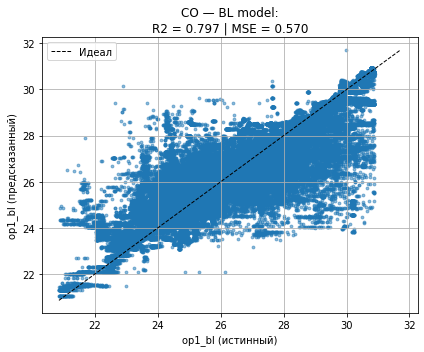

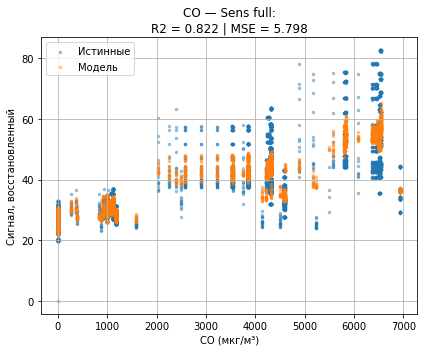


====== Итоги обучения для газа: CO (Sens) ======
Количество baseline (bl):   386254
Количество рабочих (stat):  80089
Качество baseline (BL):     R2 = 0.797 | nrMSE = 0.451
Качество sens-модели (signal): R2 = 0.822 | nrMSE = 0.421

O3: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


O3: 379707 baseline (после фильтрации)
O3: baseline = 379707, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


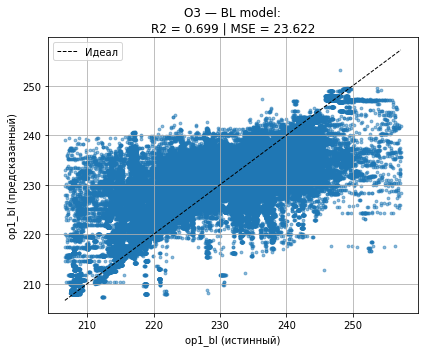

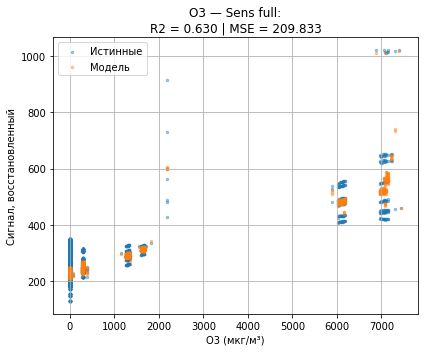


====== Итоги обучения для газа: O3 (Sens) ======
Количество baseline (bl):   376999
Количество рабочих (stat):  78411
Качество baseline (BL):     R2 = 0.699 | nrMSE = 0.549
Качество sens-модели (signal): R2 = 0.630 | nrMSE = 0.608

SO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


SO2: 361725 baseline (после фильтрации)
SO2: baseline = 361725, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


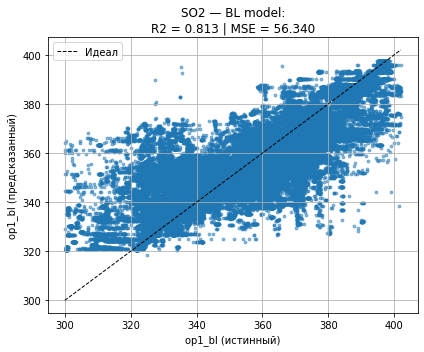

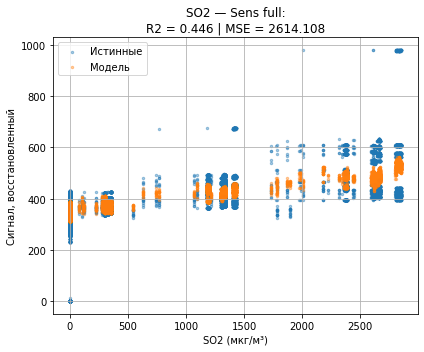


====== Итоги обучения для газа: SO2 (Sens) ======
Количество baseline (bl):   342121
Количество рабочих (stat):  73638
Качество baseline (BL):     R2 = 0.813 | nrMSE = 0.432
Качество sens-модели (signal): R2 = 0.446 | nrMSE = 0.744

H2S: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


H2S: 318300 baseline (после фильтрации)
H2S: baseline = 318300, stat = 2, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


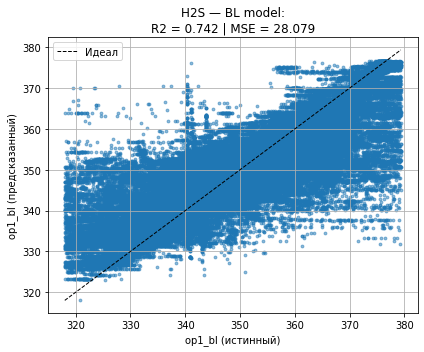

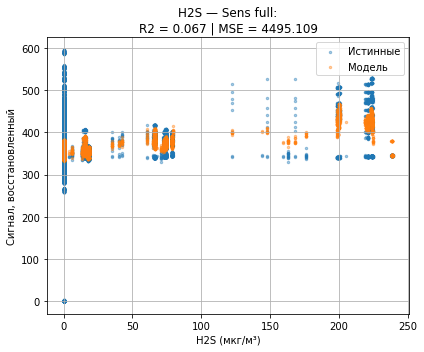


====== Итоги обучения для газа: H2S (Sens) ======
Количество baseline (bl):   302082
Количество рабочих (stat):  52928
Качество baseline (BL):     R2 = 0.742 | nrMSE = 0.508
Качество sens-модели (signal): R2 = 0.067 | nrMSE = 0.966



In [10]:

all_gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']
cross_gases_map = {
    'NO2': ['O3'],
    'CO': [],
    'O3': ['NO2'],
    'SO2': ['H2S'],
    'H2S': ['SO2']
}
for gas in all_gases:
    cross_gases = cross_gases_map.get(gas, [])
    df = load_lab_data(data_dir='data_example/lab_data', gases=[gas])
    df = add_bl_stat_masks(df, gases=[gas], std_thr=1.8, window=7, use_isolation=True, cross_gases_map=cross_gases_map)
    result_sens = train_for_gas(
        gas, df,
        bl_method='rolling',
        stat_method='auto',
        bl_model_name='catboost',
        sens_model_name='catboost',
        use_grads=False,    
        draw=True,
        cross_gases=cross_gases,
        cross_gases_in_bl=False
    )
    print_result(result_sens, mode="Sens")


NO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


NO2: 391159 baseline (после фильтрации)
NO2: baseline = 391159, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


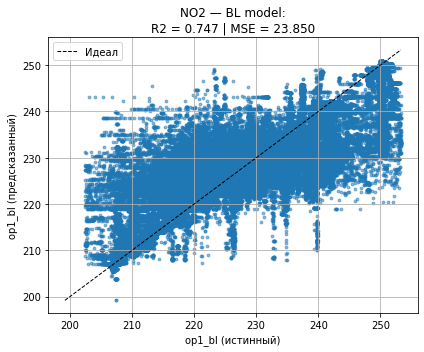

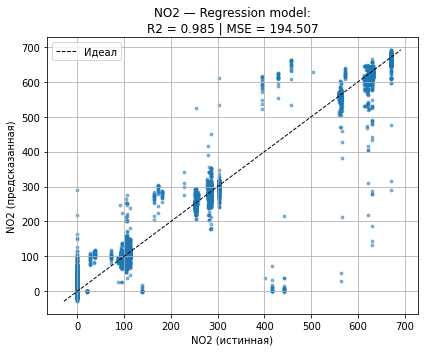


====== Итоги обучения для газа: NO2 (regr) ======
Количество baseline (bl):   387783
Количество рабочих (stat):  77644
Качество baseline (BL):     R2 = 0.747 | nrMSE = 0.503
Качество regression-модели (conc): R2 = 0.985 | nrMSE = 0.122

CO: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CO: 389660 baseline (после фильтрации)
CO: baseline = 389660, stat = 30, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


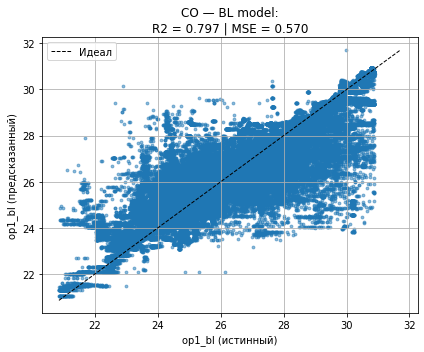

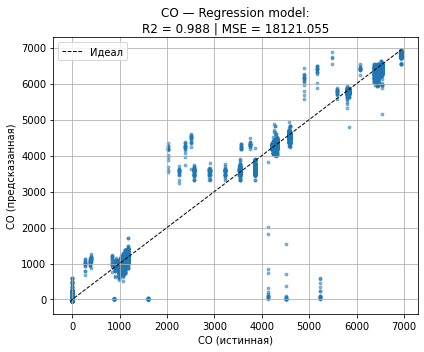


====== Итоги обучения для газа: CO (regr) ======
Количество baseline (bl):   386254
Количество рабочих (stat):  80089
Качество baseline (BL):     R2 = 0.797 | nrMSE = 0.451
Качество regression-модели (conc): R2 = 0.988 | nrMSE = 0.109

O3: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


O3: 389240 baseline (после фильтрации)
O3: baseline = 389240, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


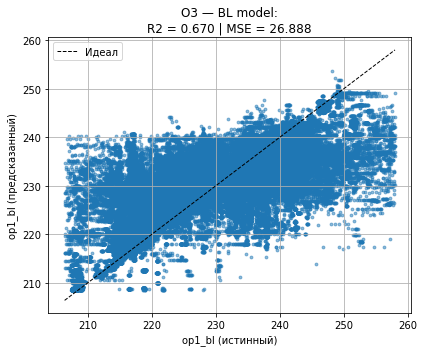

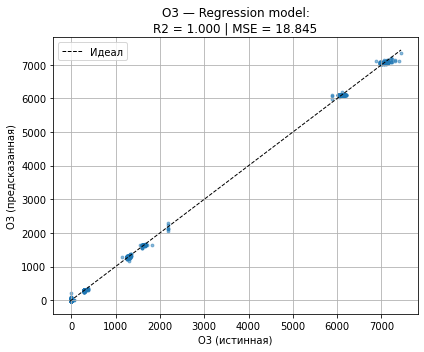


====== Итоги обучения для газа: O3 (regr) ======
Количество baseline (bl):   386532
Количество рабочих (stat):  78411
Качество baseline (BL):     R2 = 0.670 | nrMSE = 0.575
Качество regression-модели (conc): R2 = 1.000 | nrMSE = 0.012

SO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


SO2: 374403 baseline (после фильтрации)
SO2: baseline = 374403, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


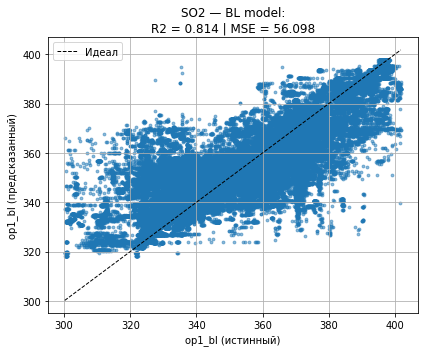

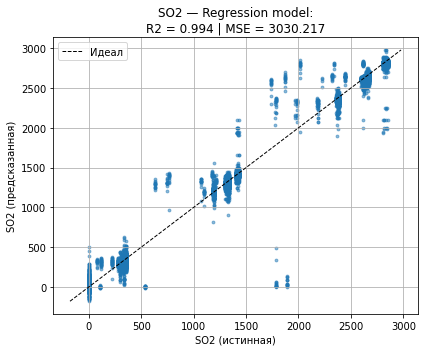


====== Итоги обучения для газа: SO2 (regr) ======
Количество baseline (bl):   354155
Количество рабочих (stat):  73638
Качество baseline (BL):     R2 = 0.814 | nrMSE = 0.432
Качество regression-модели (conc): R2 = 0.994 | nrMSE = 0.076

H2S: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


H2S: 338127 baseline (после фильтрации)
H2S: baseline = 338127, stat = 2, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


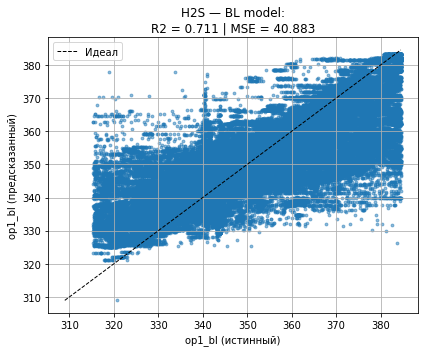

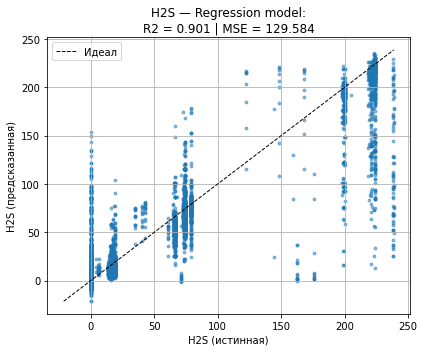


====== Итоги обучения для газа: H2S (regr) ======
Количество baseline (bl):   321350
Количество рабочих (stat):  52928
Качество baseline (BL):     R2 = 0.711 | nrMSE = 0.538
Качество regression-модели (conc): R2 = 0.901 | nrMSE = 0.314



In [9]:

for gas in all_gases:
    cross_gases = cross_gases_map.get(gas, [])
    df = load_lab_data(data_dir='data_example/lab_data', gases=[gas])
    df = add_bl_stat_masks(df, gases=[gas], std_thr=1.8, window=7, use_isolation=True)
    result_conc = train_for_gas_conc(
        gas, df,
        bl_method='rolling',
        stat_method='auto',
        bl_model_name='catboost',
        conc_model_name='catboost',
        use_grads=False,    
        draw=True,
        cross_gases=cross_gases,
        cross_gases_in_bl=False
    )
    print_result(result_conc, mode="regr")


NO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


NO2: 391159 baseline (после фильтрации)
NO2: baseline = 391159, stat = 0, всего = 921600


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


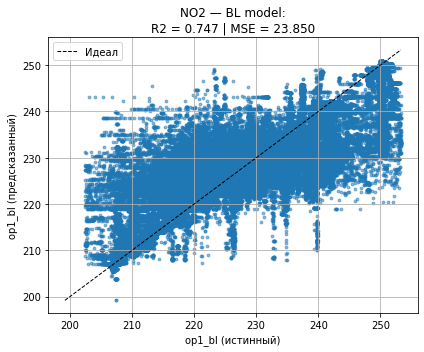

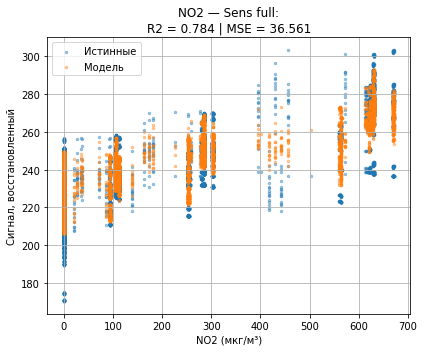


Baseline Feature Importance (BL):
  NO2t                : 55.4709
  MH                  : 44.5291

Sens Model Feature Importance:
  NO2                 : 100.0000


C:\Users\One\AppData\Local\Temp\ipykernel_13208\1506013164.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


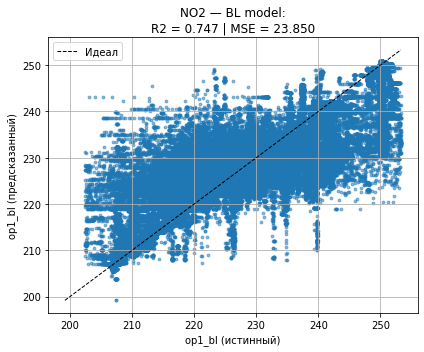

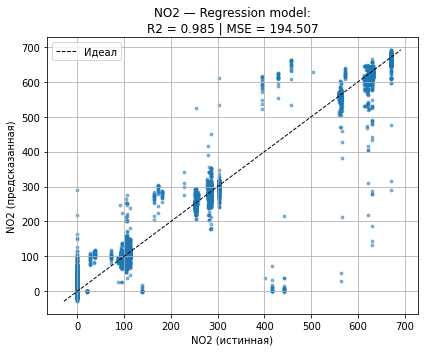


Baseline Feature Importance (BL):
  NO2t                : 55.4709
  MH                  : 44.5291

Conc Model Feature Importance:
  NO2op1              : 38.3488
  O3op1               : 33.7819
  NO2t                : 17.6305
  MH                  : 10.2388


In [11]:
def print_feature_importances(feat_imp: dict, title: str = "Feature Importance", topn=10):
    print(f"\n{title}:")
    if not feat_imp:
        print("  Нет данных о важности фич.")
        return
    for feat, imp in sorted(feat_imp.items(), key=lambda x: -abs(x[1]))[:topn]:
        print(f"  {feat:20s}: {imp:.4f}")
        
gas = 'NO2'
cross_gases = cross_gases_map.get(gas, [])

df = load_lab_data(data_dir='data_example/lab_data', gases=[gas])
df = add_bl_stat_masks(df, gases=[gas], std_thr=1.8, window=7, use_isolation=True)

result = train_for_gas(
    gas, df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    sens_model_name='catboost',
    use_grads=False,    
    draw=True,
    cross_gases=cross_gases,
    cross_gases_in_bl=False
)
print_feature_importances(result['feat_imp_bl'], title="Baseline Feature Importance (BL)")
print_feature_importances(result['feat_imp_sens'], title="Sens Model Feature Importance")
result = train_for_gas_conc(
    gas, df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    conc_model_name='catboost',
    use_grads=False,    
    draw=True,
    cross_gases=cross_gases,
    cross_gases_in_bl=False
)
print_feature_importances(result['feat_imp_bl'], title="Baseline Feature Importance (BL)")
print_feature_importances(result['feat_imp_conc'], title="Conc Model Feature Importance")


In [11]:
cross_gases

['O3']